In [ ]:
!pip install transformers datasets scikit-learn pandas --quiet


In [ ]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
import torch


df = pd.read_csv('/content/drive/MyDrive/amazonFineFoodReview/amazonDataSets/Reviews.csv')
# Sadece gerekli sütunları al
df = df[['Text', 'Score']]

# NaN kayıtları temizle
df = df.dropna()

# Etiketleri oluşturalım:
def label_sentiment(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"

df['Sentiment'] = df['Score'].apply(label_sentiment)

# Sınıf dağılımına bakalım
print(df['Sentiment'].value_counts())


Sentiment
positive    443777
negative     82037
neutral      42640
Name: count, dtype: int64


In [ ]:
# Her sınıftan 5.000 örnek al
sample_size = 5000
balanced_df = pd.concat([
    df[df['Sentiment'] == 'positive'].sample(sample_size, random_state=42),
    df[df['Sentiment'] == 'negative'].sample(sample_size, random_state=42),
    df[df['Sentiment'] == 'neutral'].sample(sample_size, random_state=42)
])

# Karıştır
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Son hali
print(balanced_df['Sentiment'].value_counts())


Sentiment
neutral     5000
negative    5000
positive    5000
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X = balanced_df['Text']
y = balanced_df['Sentiment']  # Etiketler (positive, negative, neutral)

# Eğitim ve test setine ayır
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF ile metni vektörleştir
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# Test setinde tahmin
y_pred = logreg.predict(X_test_tfidf)


Classification Report:

              precision    recall  f1-score   support

    negative       0.68      0.71      0.70      1000
     neutral       0.61      0.58      0.59      1000
    positive       0.75      0.76      0.75      1000

    accuracy                           0.68      3000
   macro avg       0.68      0.68      0.68      3000
weighted avg       0.68      0.68      0.68      3000



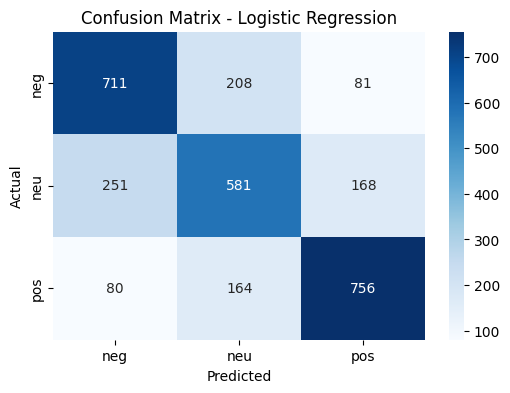

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# F1 ve diğer skorlar
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=["negative", "neutral", "positive"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "neu", "pos"], yticklabels=["neg", "neu", "pos"])
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
label2id = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}

balanced_df['label'] = balanced_df['Sentiment'].map(label2id)


In [ ]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    balanced_df['Text'].tolist(),
    balanced_df['label'].tolist(),
    test_size=0.2,
    stratify=balanced_df['label'],
    random_state=42
)


In [ ]:
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)


In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)


In [ ]:
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=3
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_dir='./logs',
    logging_steps=1000,
    save_strategy="no",
    load_best_model_at_end=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer
)

trainer.train()


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-18-01ed2b68201f>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gulsuaytac25 (gulsuaytac25-malatya-turgut-zal-niversitesi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


TrainOutput(global_step=750, training_loss=0.6852169596354166, metrics={'train_runtime': 7840.4017, 'train_samples_per_second': 1.531, 'train_steps_per_second': 0.096, 'total_flos': 397409283072000.0, 'train_loss': 0.6852169596354166, 'epoch': 1.0})

Classification Report:

              precision    recall  f1-score   support

    negative       0.76      0.73      0.74      1000
     neutral       0.66      0.71      0.69      1000
    positive       0.86      0.83      0.85      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



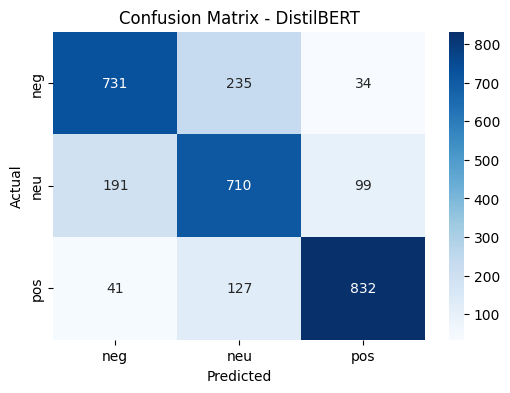

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Tahmin
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)

# Rapor
print("Classification Report:\n")
print(classification_report(val_labels, preds, target_names=["negative", "neutral", "positive"]))


# Confusion matrix
cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["neg", "neu", "pos"], yticklabels=["neg", "neu", "pos"])
plt.title("Confusion Matrix - DistilBERT")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()





In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score


In [ ]:
# Precision, Recall, F1-score ve Accuracy
print("📊 Classification Report:")
print(classification_report(val_labels, preds, target_names=["neg", "neu", "pos"]))

accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds, average='weighted')
precision = precision_score(val_labels, preds, average='weighted')
recall = recall_score(val_labels, preds, average='weighted')

print(f"\n🎯 Accuracy:  {accuracy:.4f}")
print(f"🎯 F1 Score:  {f1:.4f}")
print(f"🎯 Precision: {precision:.4f}")
print(f"🎯 Recall:    {recall:.4f}")


📊 Classification Report:
              precision    recall  f1-score   support

         neg       0.76      0.73      0.74      1000
         neu       0.66      0.71      0.69      1000
         pos       0.86      0.83      0.85      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000


🎯 Accuracy:  0.7577
🎯 F1 Score:  0.7590
🎯 Precision: 0.7612
🎯 Recall:    0.7577


In [ ]:
import pandas as pd

# Değerleri kendi sonuçlarına göre güncelle
metrics = {
    "Model": ["DistilBERT", "Logistic Regression"],
    "Accuracy": [0.75, 0.68],         # örnek
    "F1 Score": [0.75, 0.68],
    "Precision": [0.76, 0.68],
    "Recall": [0.75, 0.68]
}

df_metrics = pd.DataFrame(metrics)
print(df_metrics)


                 Model  Accuracy  F1 Score  Precision  Recall
0           DistilBERT      0.75      0.75       0.76    0.75
1  Logistic Regression      0.68      0.68       0.68    0.68


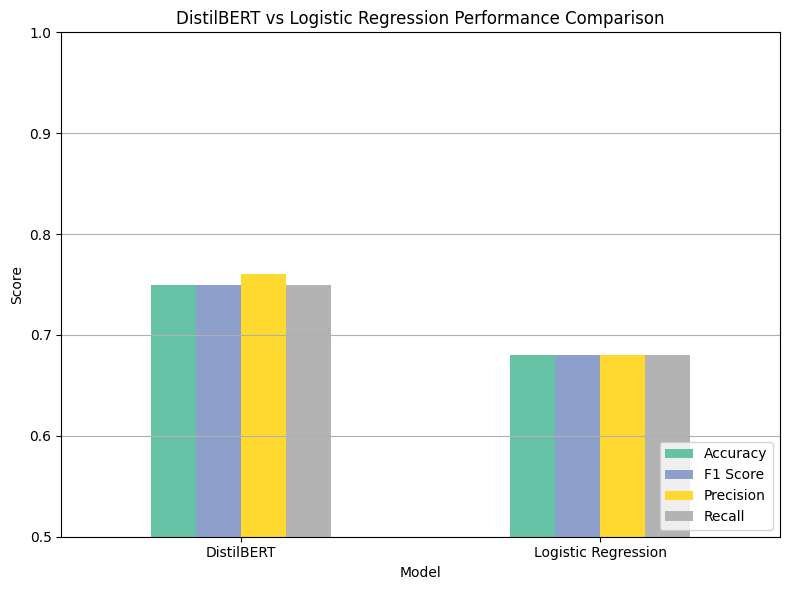

In [ ]:
df_metrics.set_index("Model")[["Accuracy", "F1 Score", "Precision", "Recall"]].plot(
    kind="bar", figsize=(8, 6), colormap="Set2", ylim=(0.5, 1.0)
)
plt.title("DistilBERT vs Logistic Regression Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
